### HCP Gambling - rfMRI analysis

This analysis aims to show whether the ACT-R models prediction (declarative model vs. RL modle) could also predict resting state brain connectivity

In [13]:
import warnings
warnings.filterwarnings('ignore')

from __future__ import division
from lasso_func import *
sns.set_style("whitegrid")

# quick mode
skip = True

In [14]:
power2011 = pd.read_csv('../bin/power_2011.csv', usecols=["ROI", "X", "Y", "Z", "Network", "Color", "NetworkName"]) 

# convert to 1/0 dummy variable 
model_dat = pd.read_csv('../actr-models/model_output/MODELLogLikelihood.csv')
model_dat['best_model1'] = np.where(model_dat['best_model']== 'm1', 1, 0)

---
### Load Subj Cocountivty Matrix

We will load **partial correlation**.  By default, the `znorm=True` is enabled, so the corr matrix is normalized to z scores using the Fisher transformation


First, let's compare different correlation matries(z transformed)

- raw: not regress out motion artifacts
- mr: motion regression
- r: peaerson correlation matrix
- pr: partial correlation


Next, convert many connectivity matries into a wide matrix `subj_wide`, with a dimension of `N`(number of subjects) x `M` (264 x 264 = 69696)

In [ ]:
#subj_wide = load_subj(model_dat)
subj_wide = load_subj(model_dat, CORR_DIR='./connectivity_matrix', TASK_DIR='/REST1/', SES_DIR='/ses-01/', corr_fname='mr_pcorr.txt', )

In [ ]:
# define dependent variable 
DV = 'best_model1' 

# check connectivity matrix
subj_wide.head()

And now, let’s visualize the histogram of the dependent variable we are trying to predict:

In [ ]:
ax = sns.countplot(DV, data=subj_wide)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:d}'.format(p.get_height()), (x.mean(), y), 
                ha = 'center', va = 'bottom')

plt.xlabel('ACT-R Model')
plt.ylabel('Number of Participants')
plt.title("The Distribution of Individuals Best Fit by ACT-R Models")
plt.gca().set_xticklabels( ('RL Model\n(model2)', 'Declarative Model\n(model1)') )
plt.gca().invert_xaxis()
plt.show()

print('DV distribution:\n', subj_wide[DV].value_counts(normalize=False))

Imbalance training data might bias the logistic model, so we need to upsample the minority class by randomly adding more data from minrority class

In [ ]:
subj_balance = balance_training_sample(subj_wide, DV)
sns.countplot(DV, data=subj_balance)
plt.title("The Distribution of ACT-R Model Prediction (Upsampled)")
plt.gca().set_xticklabels( ('model2', 'model1') )
plt.gca().invert_xaxis()
plt.show()

print('DV distribution:\n', subj_balance[DV].value_counts(normalize=False))

### Define Brain Region of Interest

Exclude some brain regions if necessary. 

Now, we obtain connectivity vector for NOI by combining `censor` with `subj_censored`

In [7]:
# define network of interest (NOI)
NOI = [
        "Uncertain",
        "Sensory/somatomotor Hand",
        "Sensory/somatomotor Mouth",
        "Cingulo-opercular Task Control",
        "Auditory",
        "Default mode",
        "Memory retrieval?",
        "Ventral attention",
        "Visual",
        "Fronto-parietal Task Control",
        "Salience",
        "Subcortical",
        "Cerebellar",
        "Dorsal attention"
]


In [8]:
censor = get_vector_df(power2011, NOI)        # filter some region connections
subj_censored = get_subj_df(subj_balance, censor)

features = list(subj_censored.columns)[2:]
print('The dimension of subj_censored is', subj_censored.shape, 'N = subj (upsampled), M = connections')

The dimension of subj_censored is (230, 34718) N = subj (upsampled), M = connections


### Logistic Regression Models

Here, we will use logistic regression with L1 penalty (LASSO) to identify the functional connectivity patterns that predict the ACT-R model outcome variable `best_model`: model1 / model2. To better fit in logistic model, this variable is changed to `best_model1` =  1/0


### Split training data and Testing set.

We will use cross-validation method (cv=10) OR leave-one-out(LOO) to find best L1 parameter `lambda`

### Grid-Search HyperParameter (lambda) Tunning

Next, let's find the best `lambda_values` for Lasso Regression using grid search hyperparameter tunning

Visualize the  `lambda` and `coef_` path

- Method1: Standard Grid Search

- Method2: Random Grid Search (more efficient)

- Method3: Halving Grid Search (even more efficient, but may not accurate)

In [9]:
if skip:
    bestC = 1/0.93260334688322
else:
    method = 'standard_gs'
    print('running >>> grid search', method)
    lambda_range = 1.0/np.logspace(-2, 2, 100)

    if method == 'standard_gs':
        # standar GS is too slow (400s +)
        grid_result = grid_search_lasso(subj_censored[features], subj_censored[DV])

    elif method == 'random_gs':
        # random GS (200s +)
        grid_result = random_grid_search_lasso(subj_censored[features], subj_censored[DV])

    elif method == 'halving_gs':
        # halving GS (100s +)
        grid_result = halving_search_lasso(subj_censored, features, DV, plot_path=True)
        
    bestC = grid_result.best_params_['C']

### Look at regularization plots

regularization path: showing the coeff changes as lambda changes

regularization score: showing the averaged accuracy score as lambda changes

In [10]:
if skip:
    coefs_ = pd.read_csv('./bin/coef_results.csv')
else:
    coefs_ = save_regularization_path(subj_censored[features], subj_censored[DV], 
                                      lambda_values = 1.0/np.logspace(-2, 2, 10),
                                      best_lambda=bestC)
    pd.DataFrame(coefs_).to_csv('./bin/coef_results.csv', index=False)

In [11]:
plt.rcParams.update({'font.size': 40})
plt.rcParams['lines.linewidth'] = 10
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

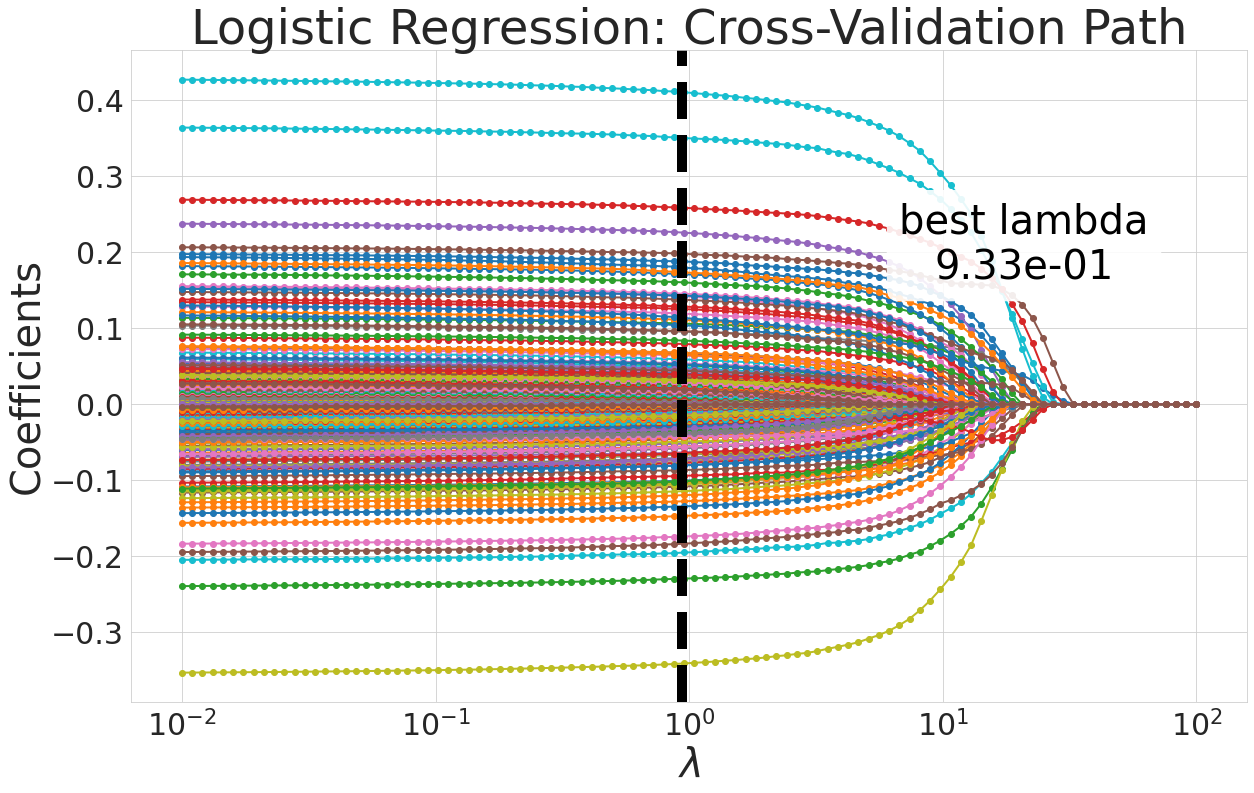

In [12]:
plot_regularization_path(coefs_, 1.0/bestC, 1.0/np.logspace(-2, 2, 100))

In [13]:
if skip:
    score_ = pd.read_csv('./bin/score_results.csv')
else:
    score_ = save_regularization_score(subj_censored[features], subj_censored[DV], bestC, num_cv=10)
    score_.to_csv('./bin/score_results.csv', index=False)

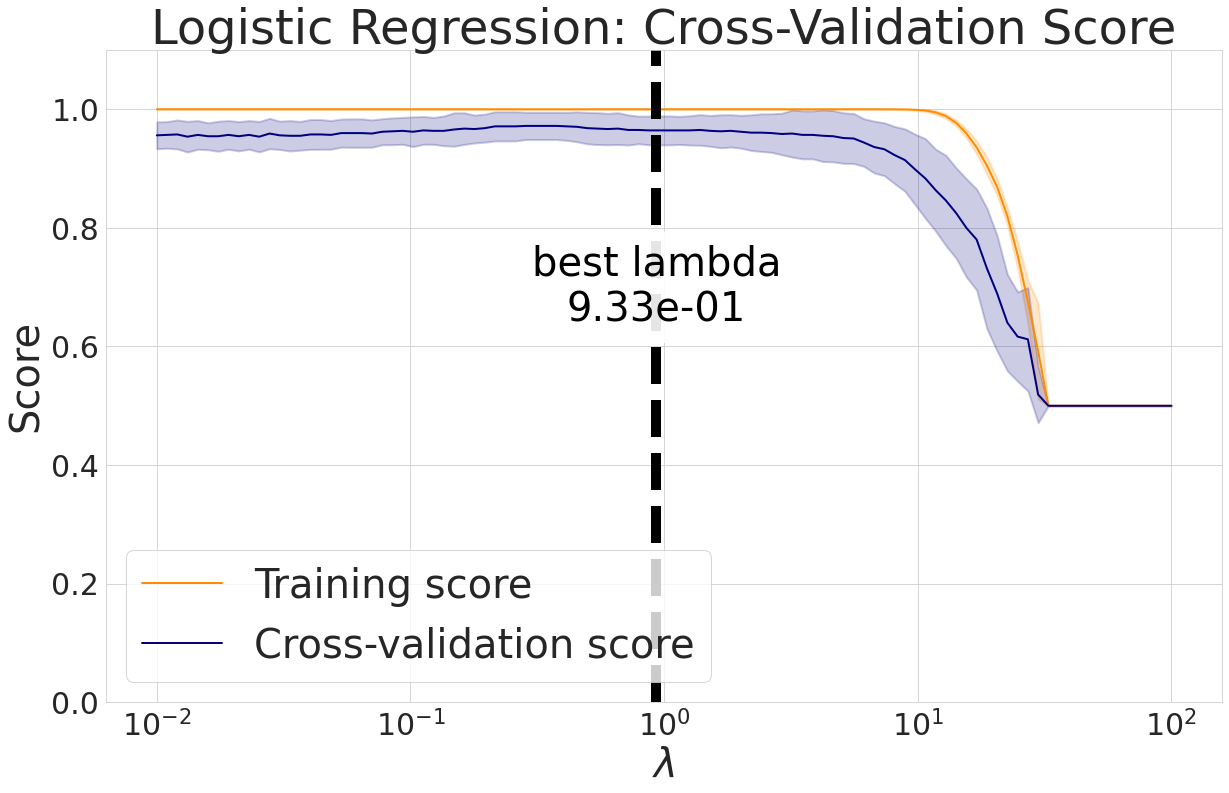

In [14]:
plot_regularization_score(score_, 1.0/bestC)

### Re-Train Logistic Model

Next, we need to retrain the logistic model with best `lambda` 


In [15]:
print('best lambda', 1.0/bestC)

best_lasso_model = LogisticRegression(penalty='l1', solver='saga', C=bestC, fit_intercept=False)
best_lasso_model.fit(subj_censored[features], subj_censored[DV])

best lambda 0.93260334688322


LogisticRegression(C=1.072267222010323, fit_intercept=False, penalty='l1',
                   solver='saga')

-  Method1: Leave-One-Out: Applying the leave-one-out(LOO) method, we can evaluate the accuracy, ROC, and confusion matrix


- Method2 Cross-Validation (20): If LOO method is tom computationally expensive, try cross-validation = 20

In [16]:
method = 'loo'
if skip:
    pred_data = pd.read_csv('./bin/loo_results.csv')
else:
    if method == 'loo':
        # LOO is computationally expensive (400s +)
        pred_data = loocv_logistic_retrain(subj_censored, features, DV, bestC)
        pred_data.to_csv('./bin/loo_results.csv')
        print('The Leave-One-Out Accuracy Score: {:.4f}'.format(accuracy_score(pred_data['ytrue'], pred_data['yhat'])))

    elif method == 'cv20':
        # CV = 20 is more efficient (200s +)
        all_ytrue, all_yhat, all_yprob, _ =cv_logistic_retrain(subj_censored, features, DV, bestC, 2)
        print('The Cross-Validation(20) Accuracy Score: {:.4f}'.format(accuracy_score(all_ytrue, all_yhat)))
    

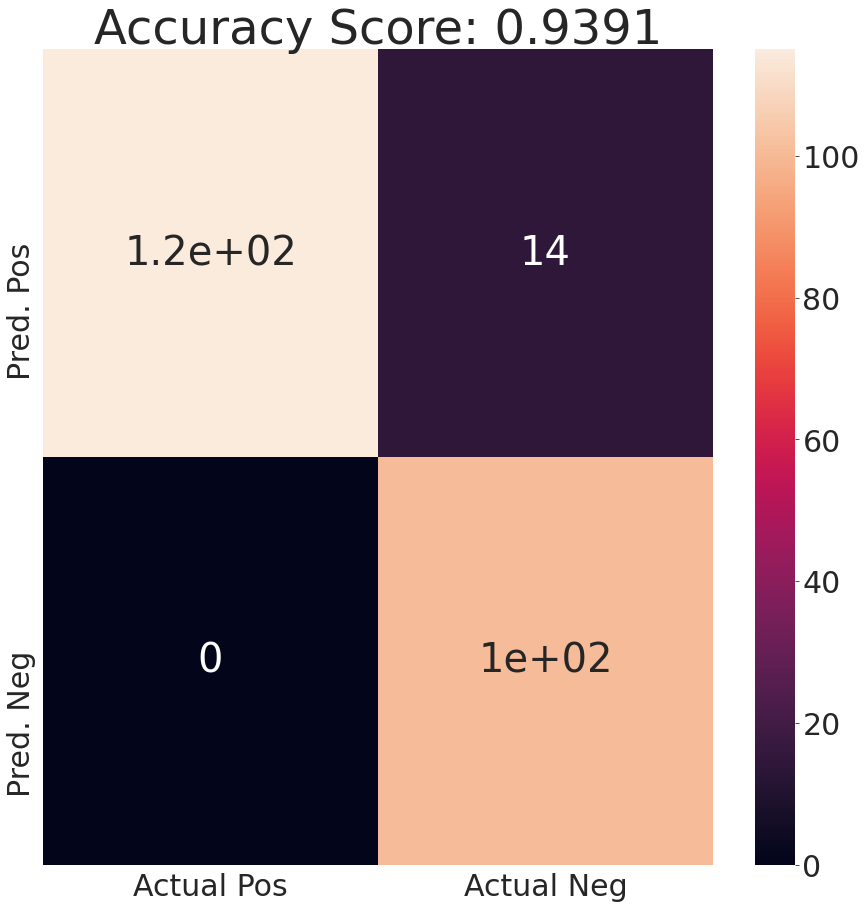

In [17]:
plot_confusion_matrix_loo(pred_data)

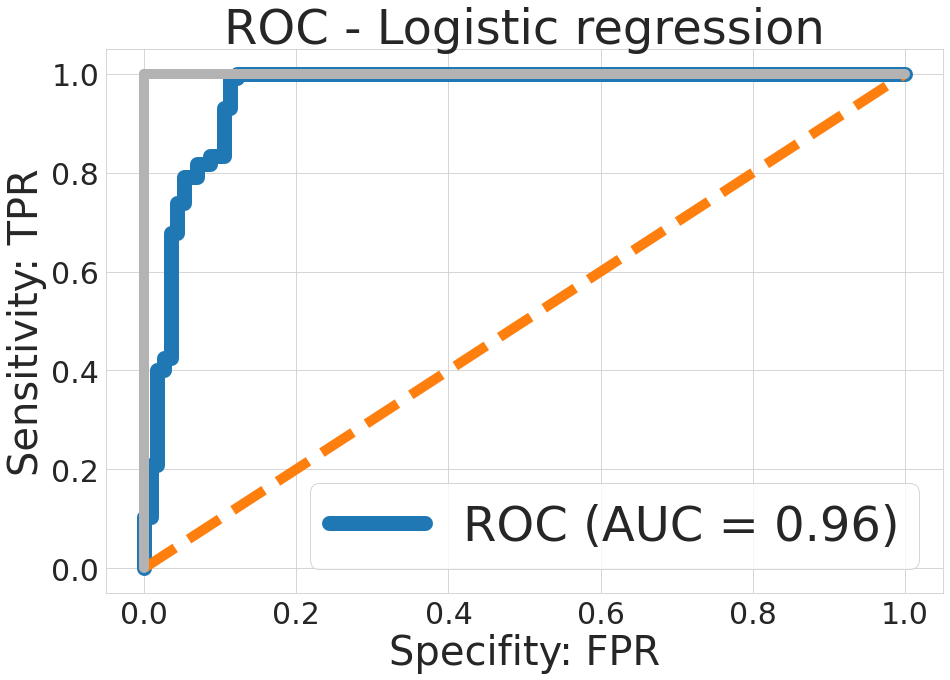

In [18]:
plot_roc_curve_loo(pred_data)

### Prediction vs. Observed


Next, let's see the predict_proba vs. observation labels

if enable `drop_dup`, the prediction plot will exclude replicated samples, and only showed true participants

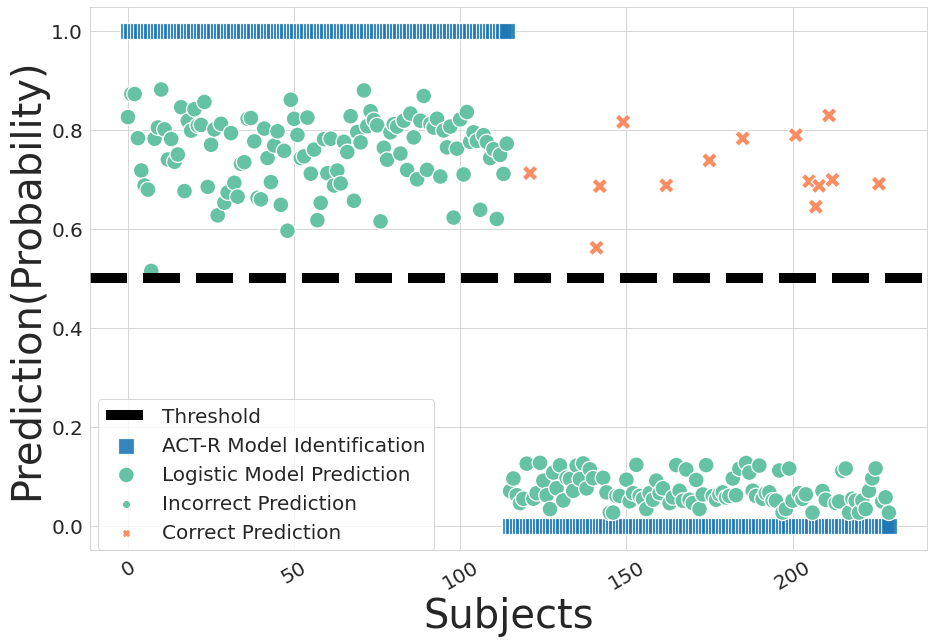

In [19]:
plot_prediction_loo(pred_data)

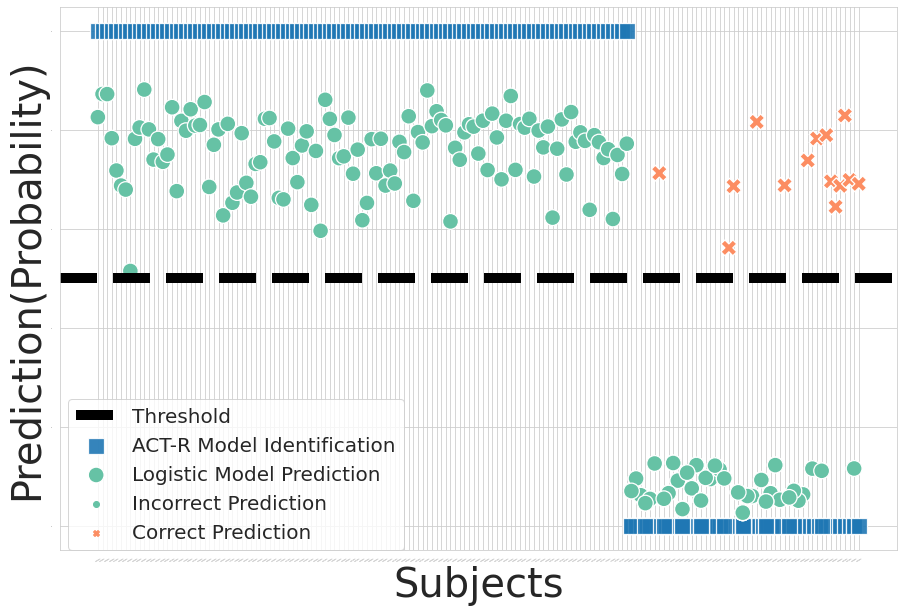

In [20]:
plot_prediction_loo(pred_data, drop_dup=True)

Let's look at strongest connections and the beta dataframe

In [21]:
betas = best_lasso_model.coef_[0]


min_connID = None
min_beta = betas[0]

max_connID = None
max_beta = betas[0]
for i in range(0, len(betas)):
    if betas[i] < min_beta:
        min_beta = betas[i]
        min_connID = features[i+1]
    if betas[i] > max_beta:
        max_beta = betas[i]
        max_connID = features[i+1]

print('min_beta', min_connID, min_beta)
print('max_beta',  max_connID, max_beta)

min_beta [221, 242] -0.03147615625522829
max_beta [155, 157] 0.046282576201813815


In [22]:
beta_df = pd.DataFrame({'connID':features, 'beta':best_lasso_model.coef_[0]})
total_bata, _ = beta_df.shape
survived_bata, _ = beta_df[beta_df['beta']!=0.0].shape

print('Total beta:', total_bata, '\nSurvive bata:', survived_bata, '\nPercentage', round(survived_bata/total_bata, 4))

Total beta: 34716 
Survive bata: 5904 
Percentage 0.1701


### Brain Mapping

Next, look at the beta value mapped on brain 

Calculate average brain corr matrix of all subjects (or weighted) and calculate `beta x averaged corr matrix` Plot new matrix?

In [23]:
beta_mat, power_coords = map_beta(censor, best_lasso_model.coef_[0], power2011)

### Average Corr Matrix across Subjects

- STEP1: transform each of the `r` to Fisher's `z`
- STEP2:  average these `z` values
- STEP3: `mean_z` is back-transformed to `mean_r`

In [24]:
# calcualte beta * averaged PR   
subj_mean_mat = average_corr(subj_wide, DV)
subj_mean_mat = pd.DataFrame(subj_mean_mat, columns=beta_mat.columns)
w_mat = beta_mat * subj_mean_mat

In [25]:
#plt.rcParams['lines.markersize'] = 30
plt.rcParams['lines.linewidth'] = 20
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

In [26]:
def plot_brain_connections(mat, power_coords, save=False, mat_name='beta_mat', thre='99.9%'):
    if mat_name=='beta_mat':
        tit = 'Beta'
    elif mat_name == 'wcorr_mat':
        tit = 'Weighted Connectivity'
    else:
        tit = 'Unknown'
    # create chart
    sns.set_style('white')
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.axis("off")

    # plot connectome with 80% edge strength in the connectivity
    plotting.plot_connectome(mat, power_coords, figure=fig,
                             edge_threshold=thre,
                             #node_color=,
                             colorbar=True,
                             node_size=0, # size 264
                             #alpha=.8,
                             title='Group analysis: ' + tit)
    if save: plt.savefig('./bin/'+mat_name+thre+'.png')
    plt.show()

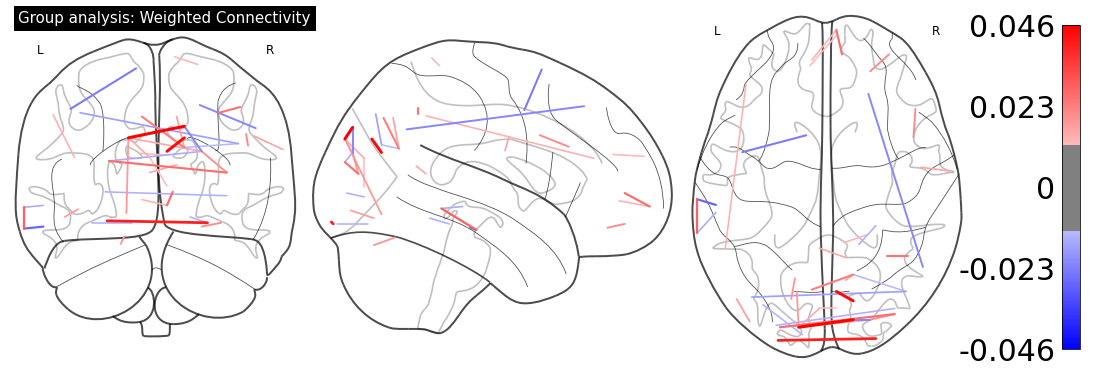

In [29]:
plot_brain_connections(w_mat, power_coords, mat_name='wcorr_mat', thre='99.9%')

In [32]:
if skip:
    wbeta = pd.read_csv('./bin/wbeta_results.csv')
else:
    wbeta = concat_wbeta(power2011, NOI, beta_df, subj_wide, w_mat, subj_mean_mat)
    wbeta.to_csv('./bin/wbeta_results.csv', index=False)

In [33]:
wbeta.head()

,connID,netID,netName,censor,beta,avg_corr,weighted_corr
0,"[1, 2]","[-1, -1]","[""Uncertain"", ""Uncertain""]",True,0.04078,0.992282,0.040465
1,"[1, 3]","[-1, -1]","[""Uncertain"", ""Uncertain""]",True,0.00000,-0.112426,-0.000000
2,"[1, 4]","[-1, -1]","[""Uncertain"", ""Uncertain""]",True,0.00000,0.282143,0.000000
3,"[1, 5]","[-1, -1]","[""Uncertain"", ""Uncertain""]",True,0.00000,-0.142369,-0.000000
4,"[1, 6]","[-1, -1]","[""Uncertain"", ""Uncertain""]",True,0.00000,-0.068697,-0.000000
